# Transformer Lab Part 2: Load and train an already pretrained Transformer [2 points]

In [ ]:
# We need to install this new library
!pip install keras-cv

In [ ]:
# Important imports go here

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_cv.models import MiTB0Backbone
import matplotlib.pyplot as plt


### Divide your original dataset into TRAIN, VAL AND TEST SPLITS (0.3 points)

In this case, we will directly use the datset from Kaggle like it was done in part 1.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from tensorflow import keras

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1


In [ ]:
base_path="/root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1" # Copy paste the path from kaggle

In [ ]:
no_dir = os.path.join(base_path, "no") # No tumor
yes_dir = os.path.join(base_path, "yes") # Tumor

# Define a function to load and resize images
def load_images_and_labels(folder, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isfile(file_path):  # We ensure it's a file
            img = cv2.imread(file_path)
            img_resized = cv2.resize(img, img_size)  # Resize to 128x128 as requested
            images.append(img_resized)
            labels.append(label)
    return images, labels

# Load images from both classes
no_tumor_images, no_tumor_labels = load_images_and_labels(no_dir, label=0)  # 0 for "No Tumor"
tumor_images, tumor_labels = load_images_and_labels(yes_dir, label=1)      # 1 for "Tumor"

# Combine images and labels
all_images = np.array(no_tumor_images + tumor_images)
all_labels = np.array(no_tumor_labels + tumor_labels)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the dataset into train, val, and test
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.2, random_state=42, stratify=temp_labels
)

# Check the result sizes
print(f"Train: {len(train_images)} images, {len(train_labels)} labels")
print(f"Validation: {len(val_images)} images, {len(val_labels)} labels")
print(f"Test: {len(test_images)} images, {len(test_labels)} labels")

Train: 177 images, 177 labels
Validation: 60 images, 60 labels
Test: 16 images, 16 labels


### Hyperparameters: We need to set the image size to 224 this time, only two classes and a batch size of 32. (0.1 points)

In [ ]:
image_size=224
batch_size=32


### Define a data augmentation pipeline with RandomFlip, RandomRotation (0.2) and RandomZoom (0.2) (0.3 points)



In [ ]:
# Reuse the previous data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size), # Ensures all input images are resized during augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [ ]:
data_augmentation.layers[0].adapt(train_images)

### Create a function to succesfully load the dataset (0.1 points)

This function was already developed:

**load_images_and_labels**

### Previously we imported MiT backbone, load it taking into account that the input_shape should be image_size + (3,) (0.3 points)

In [ ]:
# Define image size and input shape
image_size = (224, 224)  # Width, height
input_shape = image_size + (3,)  # Add the 3 channels for RGB

# Load MiT backbone
backbone = MiTB0Backbone(include_rescaling=True, input_shape=input_shape)

backbone.summary()

Model: "mi_t_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_and_embed_0                    │ (None, 3136, 32)            │           4,800 │
│ (OverlappingPatchingAndEmbedding)    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hierarchical_encoder_0_0             │ (None, 3136, 32)            │          79,616 │
│ (HierarchicalTransformerEncoder)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hierarchical_encoder_0_1             │ (None, 3136, 32)            │          79,616 │
│ (HierarchicalTransformerEncoder)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_129              │ (None, 3136, 32)            │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_level_0 (Reshape)             │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_and_embed_1                    │ (None, 784, 64)             │          18,624 │
│ (OverlappingPatchingAndEmbedding)    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hierarchical_encoder_1_0             │ (None, 784, 64)             │         118,272 │
│ (HierarchicalTransformerEncoder)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hierarchical_encoder_1_1             │ (None, 784, 64)             │         118,272 │
│ (HierarchicalTransformerEncoder)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_137              │ (None, 784, 64)             │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_level_1 (Reshape)             │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_and_embed_2                    │ (None, 196, 160)            │          92,640 │
│ (OverlappingPatchingAndEmbedding)    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hierarchical_encoder_2_0             │ (None, 196, 160)            │         418,560 │
│ (HierarchicalTransformerEncoder)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hierarchical_encoder_2_1             │ (None, 196, 160)            │         418,560 │
│ (HierarchicalTransformerEncoder)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_145              │ (None, 196, 160)            │             3

 Total params: 3,319,392 (12.66 MB)

 Trainable params: 3,319,392 (12.66 MB)

 Non-trainable params: 0 (0.00 B)

### Define the classification pipeline using the features extracted from the model (0.5 points)

In [ ]:
# Already defined
original_image_size = 128
image_size = 224
input_shape = (image_size, image_size, 3)
batch_size=32
# Additional parameters
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10 # ADAPTED
num_classes = 1 # ADAPTED
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
LAYER_NORM_EPS = 1e-6

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# New binary version of create_vit_classifier_SP
def create_vit_classifier_SP_binary():
    inputs = layers.Input(shape=(original_image_size, original_image_size, 3))
    # Augment data
    augmented = data_augmentation(inputs)

    representation = backbone(augmented)

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(representation)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Final Classification Layer
    logits = layers.Dense(num_classes, activation='sigmoid')(features)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# New binary version of run_experiment_binary
def run_experiment_binary(model):
  optimizer = tf.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.BinaryCrossentropy(from_logits=False), # APADTED
      metrics=[
          keras.metrics.BinaryAccuracy(name="accuracy"), # ADAPTED
      ],
  )

  checkpoint_filepath = "/tmp/checkpoint.weights.h5"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True,
  )

  history = model.fit(
      x=train_images, # ADAPTED
      y=train_labels, # ADAPTED
      batch_size=batch_size,
      epochs=num_epochs,
      validation_data=(val_images, val_labels), # ADAPTED
      callbacks=[checkpoint_callback],
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy = model.evaluate(val_images, val_labels) # ADAPTED
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")

  return history

### Compile and train the model (0.2 points)

In [ ]:
classifier = create_vit_classifier_SP_binary()
history = run_experiment_binary(classifier)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4633 - loss: 8.0714 - val_accuracy: 0.3833 - val_loss: 12.7186
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 972ms/step - accuracy: 0.4065 - loss: 8.4912 - val_accuracy: 0.6167 - val_loss: 2.5700
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.4829 - loss: 2.7218 - val_accuracy: 0.3833 - val_loss: 0.7066
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.4845 - loss: 3.2607 - val_accuracy: 0.6167 - val_loss: 0.6665
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4785 - loss: 2.2800 - val_accuracy: 0.6167 - val_loss: 2.4815
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5831 - loss: 2.5374 - val_accuracy: 0.6167 - val_loss: 1.6982
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.5526 - loss: 1.8259 - val_accuracy: 0.6167 - val_loss: 1.2681
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.6477 - loss: 1.4786 - val_accuracy: 0.3833 - val_loss: 

### Show train and Valiadation accuracy and loss in two different plots (0.1 points)

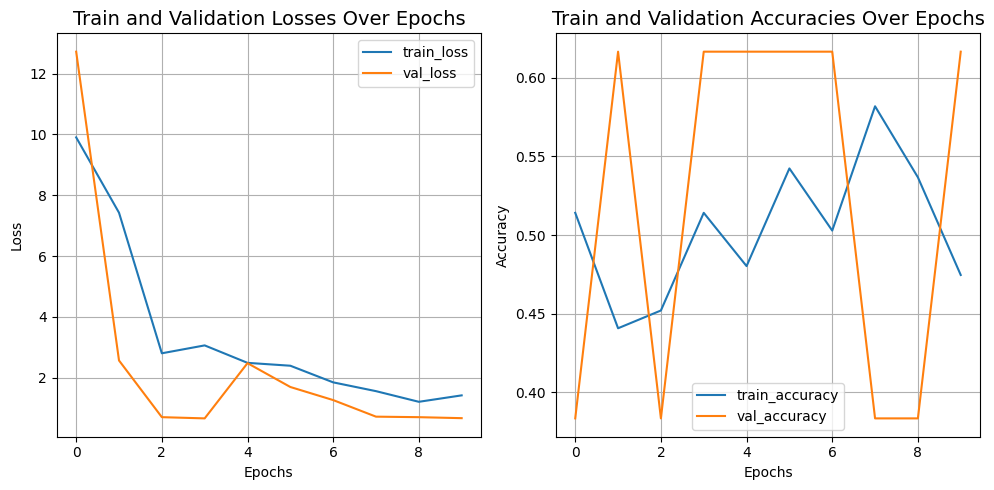

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(history.history["loss"], label="train_loss")
ax[0].plot(history.history["val_loss"], label="val_loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Train and Validation Losses Over Epochs", fontsize=14)
ax[0].legend()
ax[0].grid()
ax[1].plot(history.history["accuracy"], label="train_accuracy")
ax[1].plot(history.history["val_accuracy"], label="val_accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Train and Validation Accuracies Over Epochs", fontsize=14)
ax[1].legend()
ax[1].grid()
fig.tight_layout()
plt.show()

### Finally, test the model using evaluate (0.1 points)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[ 0  6]
 [ 0 10]]


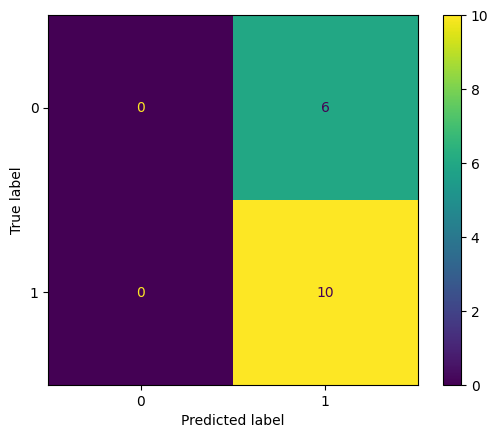

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Model
pred = classifier.predict(test_images)
pred = np.round(pred).tolist()
cm = confusion_matrix(test_labels, pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.62      1.00      0.77        10

    accuracy                           0.62        16
   macro avg       0.31      0.50      0.38        16
weighted avg       0.39      0.62      0.48        16



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


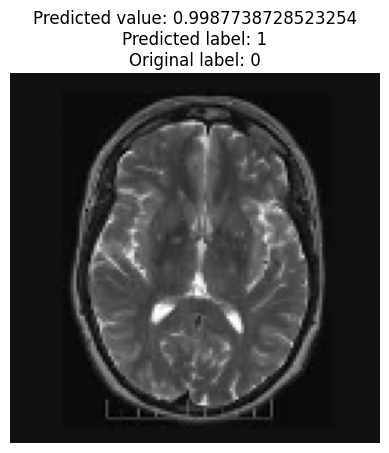

In [ ]:
# Predict one in the validation set and show results: both the original label, the predicted one and the image
index_for_predict = 3
image_to_predict = test_images[index_for_predict]
predict_true = classifier.predict(np.expand_dims(image_to_predict, axis=0))
predict = [[int(i) for i in sublist] for sublist in np.round(predict_true).tolist()]
title = f"Predicted value: {predict_true[0][0]}\n"
title += f"Predicted label: {predict[0][0]}\n"
title += f"Original label: {test_labels[index_for_predict]}"
plt.imshow(image_to_predict)
plt.title(title)
plt.axis('off')
plt.show()

## **End of Part 2: You finished!**